In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379417 sha256=74bc84ef040a2ae54620c62ddb7d013de49961f3fa646dfa5a7cea62916b8053
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create results directory
os.makedirs("results", exist_ok=True)

# Continuous action network for BipedalWalker
class ContinuousActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(ContinuousActorCritic, self).__init__()

        # Shared feature extractor
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor head (policy network)
        self.actor_mean = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Log standard deviation
        self.actor_log_std = nn.Parameter(torch.zeros(action_dim))

        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        features = self.feature(x)
        value = self.critic(features)
        action_mean = self.actor_mean(features)
        action_log_std = self.actor_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return value, action_mean, action_std

    def get_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        value, action_mean, action_std = self.forward(state)

        if deterministic:
            return action_mean.detach().cpu().numpy()[0], 0, value.item(), 0

        # Create a normal distribution
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)

        return action.detach().cpu().numpy()[0], log_prob.item(), value.item(), entropy.item()

    def evaluate_actions(self, states, actions):
        value, action_mean, action_std = self.forward(states)
        dist = Normal(action_mean, action_std)

        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1).mean()

        return value.squeeze(), log_probs, entropy

# Discrete action network for CartPole and Acrobot
class DiscreteActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions, hidden_dim=256):
        super(DiscreteActorCritic, self).__init__()

        # Shared feature extractor
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        features = self.feature(x)
        value = self.critic(features)
        policy_logits = self.actor(features)
        return value, policy_logits

    def get_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        value, policy_logits = self.forward(state)

        # Create a distribution from logits
        dist = Categorical(logits=policy_logits)

        if deterministic:
            action = torch.argmax(policy_logits, dim=1)
            return action.item(), 0, value.item(), 0

        # Sample from the distribution
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        return action.item(), log_prob.item(), value.item(), entropy.item()

    def evaluate_actions(self, states, actions):
        value, policy_logits = self.forward(states)
        dist = Categorical(logits=policy_logits)

        log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()

        return value.squeeze(), log_probs, entropy

# PPO Agent
class PPOAgent:
    def __init__(self, env, env_name, hidden_dim=256, continuous=False):
        self.env = env
        self.env_name = env_name
        self.continuous = continuous

        # Environment parameters
        self.state_dim = env.observation_space.shape[0]

        # Set up appropriate action space
        if continuous:
            self.action_dim = env.action_space.shape[0]
            self.policy = ContinuousActorCritic(self.state_dim, self.action_dim, hidden_dim=hidden_dim).to(device)
        else:
            self.action_dim = env.action_space.n
            self.policy = DiscreteActorCritic(self.state_dim, self.action_dim, hidden_dim=hidden_dim).to(device)

        # Environment-specific hyperparameters
        if env_name == "CartPole-v1":
            self.lr = 0.0001
            self.gamma = 0.99
            self.gae_lambda = 0.95
            self.clip_ratio = 0.2
            self.entropy_coef = 0.01
            self.value_coef = 0.5
            self.max_grad_norm = 0.5
            self.update_epochs = 10
            self.batch_size = 64
            self.min_batch_size = 1000
            self.solve_threshold = 475
        elif env_name == "Acrobot-v1":
            self.lr = 0.0003
            self.gamma = 0.995
            self.gae_lambda = 0.97
            self.clip_ratio = 0.2
            self.entropy_coef = 0.02
            self.value_coef = 0.5
            self.max_grad_norm = 0.5
            self.update_epochs = 12
            self.batch_size = 64
            self.min_batch_size = 1200
            self.solve_threshold = -100
        elif env_name == "BipedalWalker-v3":
            self.lr = 0.0003
            self.gamma = 0.99
            self.gae_lambda = 0.95
            self.clip_ratio = 0.2
            self.entropy_coef = 0.001
            self.value_coef = 0.5
            self.max_grad_norm = 0.5
            self.update_epochs = 10
            self.batch_size = 128
            self.min_batch_size = 2048
            self.solve_threshold = 300

        # Initialize optimizer
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=200, gamma=0.9)

        # Memory buffers
        self.reset_buffers()

        # Episode statistics
        self.episode_rewards = []
        self.running_reward = 0
        self.best_reward = float('-inf')
        self.timestep = 0

    def reset_buffers(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []

    def remember(self, state, action, log_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

        self.timestep += 1

    def compute_gae(self, next_value):
        advantages = []
        returns = []
        gae = 0

        # Convert to numpy arrays for faster computation
        rewards = np.array(self.rewards)
        if self.env_name == "BipedalWalker-v3":
            values = np.array(self.values + [next_value.cpu().item()])
        else:
            values = np.array(self.values + [next_value])
        dones = np.array(self.dones)

        # Calculate returns and advantages
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step + 1] * (1 - dones[step]) - values[step]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[step]) * gae
            advantages.insert(0, gae)
            returns.insert(0, gae + values[step])

        return advantages, returns

    def update(self, next_value):
        # Don't update with small batches
        if len(self.states) < self.min_batch_size:
            return

        # Compute advantages and returns
        advantages, returns = self.compute_gae(next_value)

        # Convert to tensors
        states = torch.FloatTensor(np.array(self.states)).to(device)
        if self.continuous:
            actions = torch.FloatTensor(np.array(self.actions)).to(device)
        else:
            actions = torch.LongTensor(np.array(self.actions)).to(device)
        old_log_probs = torch.FloatTensor(np.array(self.log_probs)).to(device)
        returns = torch.FloatTensor(returns).to(device)
        advantages = torch.FloatTensor(advantages).to(device)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Mini-batch training
        batch_size = self.batch_size

        # Optimize policy for multiple epochs
        for _ in range(self.update_epochs):
            # Create random indices
            indices = torch.randperm(states.size(0))

            for start_idx in range(0, states.size(0), batch_size):
                # Select mini-batch
                end_idx = min(start_idx + batch_size, states.size(0))
                mb_indices = indices[start_idx:end_idx]

                # Get mini-batch data
                mb_states = states[mb_indices]
                mb_actions = actions[mb_indices]
                mb_old_log_probs = old_log_probs[mb_indices]
                mb_returns = returns[mb_indices]
                mb_advantages = advantages[mb_indices]

                # Forward pass
                values, log_probs, entropy = self.policy.evaluate_actions(mb_states, mb_actions)

                # Calculate ratio (importance sampling)
                ratio = torch.exp(log_probs - mb_old_log_probs)

                # Clipped objective function
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * mb_advantages

                # PPO losses
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(values, mb_returns)

                # Total loss
                loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy

                # Update the policy
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.optimizer.step()

        # Update learning rate
        self.lr_scheduler.step()

        # Clear memory
        self.reset_buffers()

    def train(self, max_episodes=1000, max_timesteps=1000, print_interval=10):
        start_time = datetime.now()
        episode_durations = []
        episode_rewards_list = []
        solved_flag = False

        for episode in range(max_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            episode_steps = 0

            for t in range(max_timesteps):
                # Select action
                with torch.no_grad():
                    action, log_prob, value, _ = self.policy.get_action(state)

                # Take action
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                # Custom reward shaping
                shaped_reward = reward

                # Apply reward shaping for specific environments
                if self.env_name == "Acrobot-v1":
                    # Reward shaping for Acrobot: reward progress towards goal
                    position = -np.cos(state[0]) - np.cos(state[1] + state[0])
                    next_position = -np.cos(next_state[0]) - np.cos(next_state[1] + next_state[0])
                    progress_reward = (next_position - position) * 10  # Scale the progress
                    shaped_reward = reward + progress_reward

                # Store experience
                self.remember(state, action, log_prob, value, shaped_reward, done)

                state = next_state
                episode_reward += reward  # Track original rewards for reporting
                episode_steps += 1

                if len(self.states) >= self.min_batch_size:
                    # Update policy
                    with torch.no_grad():
                        if done:
                            next_value = 0.0
                        else:
                            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
                            if self.env_name == "BipedalWalker-v3":
                                next_value, _, _ = self.policy.forward(next_state_tensor)
                            else:
                                next_value, _ = self.policy(next_state_tensor)
                                next_value = next_value.item()

                    self.update(next_value)

                if done:
                    break

            # Update at the end of episode if there's still data
            if len(self.states) > 0 and episode_steps >= 5:  # Only update if reasonable episode length
                with torch.no_grad():
                    if done:
                        next_value = 0.0
                    else:
                        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
                        if self.env_name == "BipedalWalker-v3":
                            next_value, _, _ = self.policy.forward(next_state_tensor)
                        else:
                            next_value, _ = self.policy(next_state_tensor)
                            next_value = next_value.item()

                self.update(next_value)

            # Record episode stats
            episode_rewards_list.append(episode_reward)
            episode_durations.append(episode_steps)

            # Update best reward
            if episode_reward > self.best_reward:
                self.best_reward = episode_reward

            # Update running reward for early stopping check
            if episode == 0:
                self.running_reward = episode_reward
            else:
                self.running_reward = 0.05 * episode_reward + 0.95 * self.running_reward

            # Print episode statistics
            if episode % print_interval == 0:
                elapsed_time = datetime.now() - start_time
                print(f"Episode: {episode}, steps: {episode_steps}, reward: {episode_reward:.2f}, running: {self.running_reward:.2f}, best: {self.best_reward:.2f}, time: {elapsed_time}")

            # Check if environment is solved
            if self.running_reward >= self.solve_threshold:
                if not solved_flag:
                    print(f"Environment solved in {episode} episodes! Running reward: {self.running_reward:.2f}")
                    solved_flag = True

                    # Save the model
                    torch.save(self.policy.state_dict(), f"results/{self.env_name}_ppo_solved.pt")
                    break

            # Save the best model periodically
            if episode % 100 == 0 and episode > 0:
                torch.save(self.policy.state_dict(), f"results/{self.env_name}_ppo_episode_{episode}.pt")

        # Save final model
        torch.save(self.policy.state_dict(), f"results/{self.env_name}_ppo_final.pt")

        return episode_rewards_list, episode_durations

    def evaluate(self, num_episodes=10, render=False):
        rewards = []

        for _ in range(num_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                # Select action deterministically
                action, _, _, _ = self.policy.get_action(state, deterministic=True)

                # Take action
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                state = next_state
                episode_reward += reward

                if render:
                    self.env.render()

            rewards.append(episode_reward)

        return np.mean(rewards), np.std(rewards)

# Train function for a specific environment
def train_environment(env_name, max_episodes=1000, hidden_dim=256):
    # Check if environment uses continuous or discrete actions
    env = gym.make(env_name)
    continuous = isinstance(env.action_space, gym.spaces.Box)

    # Set appropriate hidden dimension based on environment
    if env_name == "CartPole-v1":
        hidden_dim = 256
        max_episodes = 600
        agent = PPOAgent(env, env_name, hidden_dim=hidden_dim, continuous=continuous)
    elif env_name == "Acrobot-v1":
        hidden_dim = 512
        max_episodes = 800
        agent = PPOAgent(env, env_name, hidden_dim=hidden_dim, continuous=continuous)
    elif env_name == "BipedalWalker-v3":
        env = gym.make(env_name, render_mode='human')
        agent = PPOAgent(env, env_name, hidden_dim=hidden_dim, continuous=True)
        hidden_dim = 512
        max_episodes = 1000

    # Create and train agent
    rewards, durations = agent.train(max_episodes=max_episodes)

    # Save results
    np.save(f"results/{env_name}_rewards.npy", rewards)
    np.save(f"results/{env_name}_durations.npy", durations)

    # Evaluate the trained agent
    mean_reward, std_reward = agent.evaluate(num_episodes=10)
    print(f"Evaluation - Mean reward: {mean_reward:.2f}, Std: {std_reward:.2f}")

    env.close()
    return rewards, agent

# Plot learning curves
def plot_learning_curve(rewards, env_name, window=10):
    # Ensure directory exists
    os.makedirs("plots", exist_ok=True)

    plt.figure(figsize=(10, 6))

    # Original rewards
    plt.plot(rewards, alpha=0.3, color='blue', label='Rewards')

    # Smoothed rewards
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), smoothed, color='blue', label=f'Smoothed (window={window})')

    # Environment-specific threshold line
    if env_name == "CartPole-v1":
        plt.axhline(y=475, color='r', linestyle='--', label='Solve Threshold (475)')
    elif env_name == "Acrobot-v1":
        plt.axhline(y=-100, color='r', linestyle='--', label='Solve Threshold (-100)')
    elif env_name == "BipedalWalker-v3":
        plt.axhline(y=300, color='r', linestyle='--', label='Solve Threshold (300)')

    plt.title(f'PPO Learning Curve - {env_name}')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)

    # Save the figure
    plt.savefig(f"plots/{env_name}_learning_curve.png")
    plt.close()


Using device: cuda


In [7]:
print(f"\nTraining on CartPole-v1")
rewards, _ = train_environment("CartPole-v1")
plot_learning_curve(rewards, "CartPole-v1")


Training on CartPole-v1
Episode: 0, steps: 19, reward: 19.00, running: 19.00, best: 19.00, time: 0:00:01.475586
Episode: 10, steps: 26, reward: 26.00, running: 22.02, best: 43.00, time: 0:00:02.075478
Episode: 20, steps: 24, reward: 24.00, running: 21.47, best: 43.00, time: 0:00:02.558767
Episode: 30, steps: 26, reward: 26.00, running: 20.98, best: 43.00, time: 0:00:03.243216
Episode: 40, steps: 13, reward: 13.00, running: 22.89, best: 59.00, time: 0:00:03.593603
Episode: 50, steps: 27, reward: 27.00, running: 23.08, best: 67.00, time: 0:00:05.157937
Episode: 60, steps: 18, reward: 18.00, running: 24.09, best: 67.00, time: 0:00:05.549198
Episode: 70, steps: 9, reward: 9.00, running: 25.46, best: 69.00, time: 0:00:05.950277
Episode: 80, steps: 27, reward: 27.00, running: 27.98, best: 69.00, time: 0:00:07.163937
Episode: 90, steps: 58, reward: 58.00, running: 30.77, best: 69.00, time: 0:00:07.563095
Episode: 100, steps: 12, reward: 12.00, running: 28.59, best: 69.00, time: 0:00:07.85556

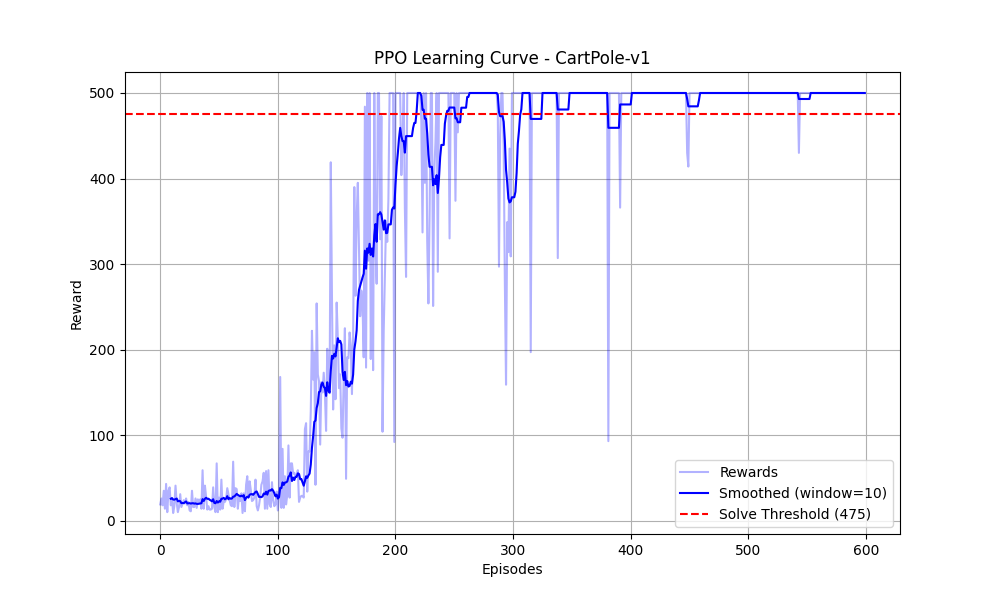

In [20]:
from IPython.display import Image, display
display(Image(filename='/content/plots/CartPole-v1_learning_curve.png'))


In [8]:
print(f"\nTraining on Acrobot-v1")
rewards, _ = train_environment("Acrobot-v1")
plot_learning_curve(rewards, "Acrobot-v1")


Training on Acrobot-v1
Episode: 0, steps: 500, reward: -500.00, running: -500.00, best: -500.00, time: 0:00:00.705073
Episode: 10, steps: 500, reward: -500.00, running: -500.00, best: -500.00, time: 0:00:11.574527
Episode: 20, steps: 500, reward: -500.00, running: -500.00, best: -500.00, time: 0:00:22.187086
Episode: 30, steps: 212, reward: -211.00, running: -422.88, best: -211.00, time: 0:00:29.633310
Episode: 40, steps: 161, reward: -160.00, running: -335.48, best: -160.00, time: 0:00:34.425698
Episode: 50, steps: 119, reward: -118.00, running: -258.78, best: -103.00, time: 0:00:37.713290
Episode: 60, steps: 102, reward: -101.00, running: -204.62, best: -98.00, time: 0:00:40.376265
Episode: 70, steps: 141, reward: -140.00, running: -173.81, best: -82.00, time: 0:00:43.025909
Episode: 80, steps: 127, reward: -126.00, running: -168.22, best: -82.00, time: 0:00:46.252384
Episode: 90, steps: 128, reward: -127.00, running: -147.78, best: -79.00, time: 0:00:49.196379
Episode: 100, steps: 

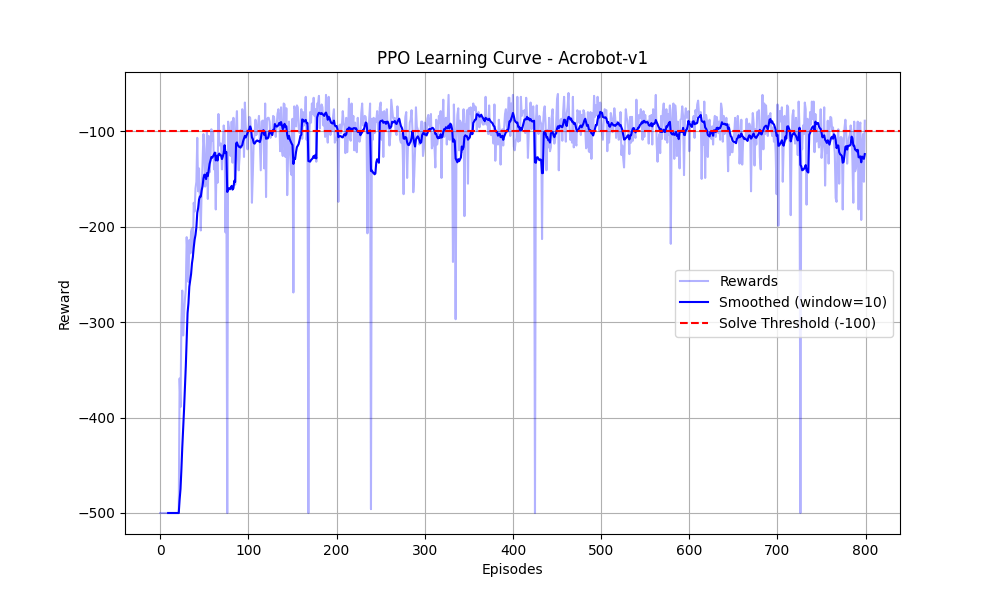

In [21]:
display(Image(filename='/content/plots/Acrobot-v1_learning_curve.png'))

In [ ]:
print(f"\nTraining on BipedalWalker-v3")
rewards, _ = train_environment("BipedalWalker-v3")
plot_learning_curve(rewards, "BipedalWalker-v3")


Training on BipedalWalker-v3
Episode: 0, steps: 1000, reward: -71.62, running: -71.62, best: -71.62, time: 0:00:20.269254
Episode: 10, steps: 105, reward: -111.12, running: -78.69, best: -57.66, time: 0:02:12.116365
Episode: 20, steps: 105, reward: -116.50, running: -86.24, best: -54.98, time: 0:03:24.978827
Episode: 30, steps: 124, reward: -123.62, running: -90.98, best: -51.17, time: 0:04:38.372056
Episode: 40, steps: 67, reward: -113.25, running: -93.40, best: -51.17, time: 0:05:50.442774
Episode: 50, steps: 53, reward: -108.89, running: -95.47, best: -51.17, time: 0:07:03.813525
Episode: 60, steps: 1000, reward: -60.28, running: -94.86, best: -51.17, time: 0:08:34.638526
Episode: 70, steps: 1000, reward: -48.02, running: -81.99, best: -45.87, time: 0:11:22.032825
Episode: 80, steps: 1000, reward: -43.57, running: -72.39, best: -41.25, time: 0:14:09.936197
Episode: 90, steps: 1000, reward: -40.13, running: -68.78, best: -40.13, time: 0:16:38.327746
Episode: 100, steps: 1000, reward